# Bayesian regression, four ways

In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Univariate normal distribution
Let's try to infer the most likely parameters of a normal distribution given some data ($y$).
We'll generate some data (of size $N = 100$) with known parameters $\mu = 0$ and $\sigma = 1$:

\begin{align}
y \sim N(0, 1)
\end{align}

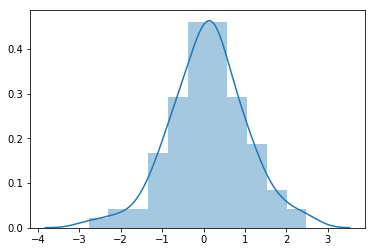

In [48]:
N = 100
y = np.random.normal(0, 1, size=N)

sns.distplot(y)

Now, the analytical (estimated) mean is calculated as:

\begin{align}
\bar{y} = \frac{1}{N}\sum_{i}^{N}y_{i} 
\end{align}

And the analytical standard deviation is calculated as:

\begin{align}
s = \frac{1}{N}\sum_{i}^{N}(y_{i} - \bar{y})^2
\end{align}

Let's do just that:

In [3]:
y_est_mean = np.mean(y)
y_est_sd = np.std(y)

print('Estimated mean: %.3f' % y_est_mean)
print('Estimated sd: %.3f' % y_est_sd)

Estimated mean: -0.194
Estimated sd: 0.940


Now, how about a bayesian estimation?

\begin{align}
p(\theta \mid y) \propto p(y \mid \theta)p(\theta)
\end{align}

Let's use completely flat priors to mimic the analytical solution:

In [4]:
model = pm.Model()

with model:
    
    mu = pm.Flat('mu')
    sigma = pm.Uniform('sigma', lower=0, upper=10**6)
    y_obs = pm.Normal('y_obs', mu=mu, sd=sigma, observed=y)
    trace_ndist = pm.sample(cores=2, discard_tuned_samples=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mu]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:01<00:00, 1632.80draws/s]


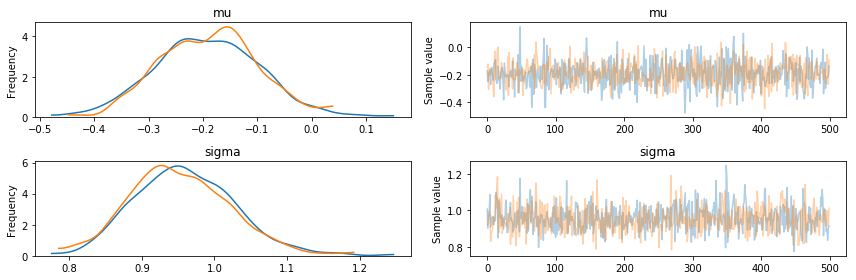

Estimated mean, bayesian: -0.192
Estimated sd, bayesian: 0.956


In [5]:
pm.traceplot(trace_ndist)
plt.show()

y_est_mean_bayes = np.mean(trace_ndist['mu'])
y_est_sd_bayes = np.mean(trace_ndist['sigma'])

print('Estimated mean, bayesian: %.3f' % y_est_mean_bayes)
print('Estimated sd, bayesian: %.3f' % y_est_sd_bayes)

Close enough!

## OLS regression
Now, let's also generate some independent variable, $X$, which we'll use to re-generate our $y$ variable:

\begin{align}
y = X\beta + \epsilon \sim N(0, 1)
\end{align}

In [49]:
X = np.random.normal(0, 1, size=N)
X = np.c_[np.ones(N), X]
epsilon = np.random.normal(0, 2, size=N)
betas = np.array([1, 2])
y = X.dot(betas) + epsilon

Now, let's first estimate the parameters ($\beta$) using the analytical version (OLS):

\begin{align}
\hat{\beta} = (X^{T}X)^{-1}X^{T}y
\end{align}

In [50]:
betas_ols = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
sigmasq_ols = np.sum((y - X.dot(betas_ols)) ** 2) / (N - 2)
covar_betas_ols = sigmasq_ols * np.linalg.inv(X.T.dot(X))
print('Estimated params, OLS: %s' % (betas_ols,))
print('Estimated sigma, OLS: %s' % (sigmasq_ols,))

covar_betas_ols

Estimated params, OLS: [1.20825816 2.0470695 ]
Estimated sigma, OLS: 3.722403226616519


array([[0.03747208, 0.00279292],
       [0.00279292, 0.03144694]])

And the Bayesian way:

\begin{align}
y \sim N(X\beta, \sigma I)
\end{align}

In [62]:
ols_model = pm.Model()

with ols_model:
    betas_bayes = pm.Flat('betas', shape=2)
    sigma_bayes = pm.Uniform('sigma', lower=0, upper=10**6)
    y_obs = pm.Normal('y_obs', mu=pm.math.dot(X, betas_bayes), sd=sigma_bayes, observed=y)
    trace_ols = pm.sample(10000, cores=2)
    map_est = pm.find_MAP()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, betas]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:08<00:00, 2342.99draws/s]
logp = -220.44, ||grad|| = 1.5631: 100%|██████████| 26/26 [00:00<00:00, 2130.46it/s]          


In [63]:
betas_est_bayes = np.mean(trace_ols['betas'], axis=0)
sd_est_bayes = np.mean(trace_ols['sigma'])
print('Estimated params, bayes: %s' % (betas_est_bayes,))
print('Estimated sd, bayes: %s' % (sd_est_bayes,))

Estimated params, bayes: [1.2084373  2.04895212]
Estimated sd, bayes: 1.9527385606381242


Note that the (co)variance of the posterior distributions of the parameters ($\beta$) is (approximately) the same as the analytical (OLS) solution when assuming a flat prior over the parameters. 

In [10]:
np.cov(trace_ols['betas'].T)

array([[ 0.04293036, -0.0003893 ],
       [-0.0003893 ,  0.04236129]])

Actually, isn't it a multivariate normal distribution of the noise?

In [60]:
ols_model = pm.Model()

with ols_model:
    betas_bayes = pm.Flat('betas', shape=2)
    sigma_bayes = pm.Uniform('sigma', lower=0, upper=10**6)
    cov = sigma_bayes**2 * np.eye(N)
    y_obs = pm.MvNormal('y_obs', mu=pm.math.dot(X, betas_bayes), cov=cov, observed=y)
    trace_ols = pm.sample(2000, cores=2)
    map_est = pm.find_MAP()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, betas]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:42<00:00, 237.26draws/s]
The acceptance probability does not match the target. It is 0.887025307905267, but should be close to 0.8. Try to increase the number of tuning steps.
logp = -220.44, ||grad|| = 1.5631: 100%|██████████| 26/26 [00:00<00:00, 409.83it/s]          


Estimated params, bayes: [1.20791046 2.0431247 ]
Estimated sd, bayes: 1.9535177542914153


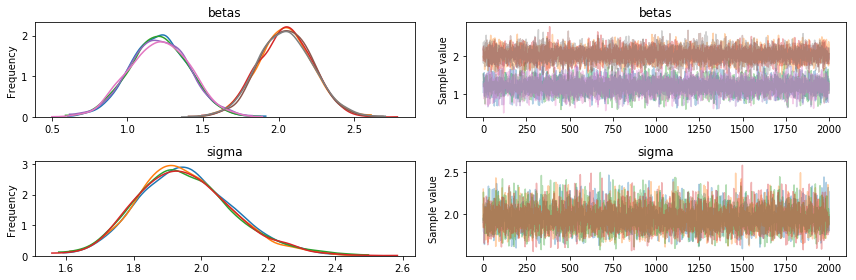

In [61]:
pm.traceplot(trace_ols)
betas_est_bayes = np.mean(trace_ols['betas'], axis=0)
sd_est_bayes = np.mean(trace_ols['sigma'])
print('Estimated params, bayes: %s' % (betas_est_bayes,))
print('Estimated sd, bayes: %s' % (sd_est_bayes,))

Also, it's actually quite easy to run a (bayesian) GLM with OLS-like likelihoods (Gaussian) and priors (flat) using the `glm` module of pymc3:

In [11]:
data = pd.DataFrame({'X1': X[:, 1], 'y': y})
with pm.Model() as model:
    pm.glm.GLM.from_formula('y ~ X1', data=data,
                            family='normal',
                            priors=None)
    
    trace = pm.sample(2000, cores=2)

print(np.mean(trace['Intercept'], axis=0))
print(np.mean(trace['X1'], axis=0))
print(np.mean(trace['sd'], axis=0))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, X1, Intercept]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:02<00:00, 2274.74draws/s]

0.8181003299882122
1.893861823798281
2.06173819501945


Same same!

## GLS
When the noise cannot be assumed to be independent (i.e., there is autocorrelation), generalized least squares (GLS) is a more efficient estimator than OLS.

In Bayesian terms, we assume that $y$ is distributed as:

\begin{align}
y \sim N(X\beta, \sigma^2 V)
\end{align}

where $V$ is the covariance matrix of the noise, which has non-zero elements.

Suppose that we have found a way to reliably estimate $V$. Now, we can show that the variance of the GLS estimator is less than the OLS estimator:

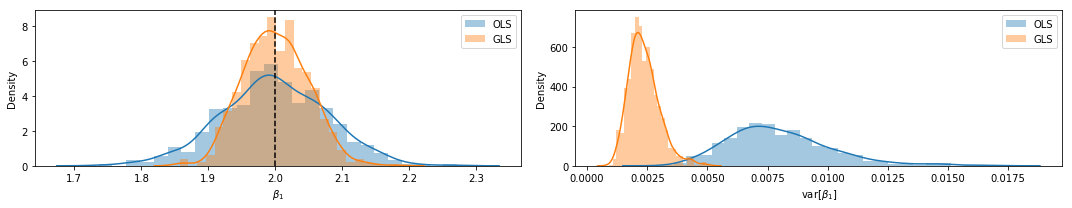

In [96]:
V = 0.75**sp.linalg.toeplitz(np.arange(N))

iters = 1000
betas_ols = np.zeros((iters, 2))
betas_gls = np.zeros((iters, 2))
variance_ols = np.zeros((iters, 2))
variance_gls = np.zeros((iters, 2))

for i in range(iters):
    epsilon = np.random.multivariate_normal(np.zeros(N), cov=V)
    y_gls = X.dot(betas) + epsilon
    betas_ols[i, :] = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y_gls)
    variance_ols[i, :] = np.diagonal(np.sum((y_gls - X.dot(betas_ols[i, :]))**2) / (N - 2) * np.linalg.inv(X.T.dot(X)))
    V_inv = np.linalg.inv(V)
    betas_gls[i, :] = np.linalg.inv(X.T.dot(V_inv).dot(X)).dot(X.T).dot(V_inv).dot(y_gls)
    variance_gls[i, :] = np.diagonal(np.sum((y_gls - X.dot(betas_gls[i, :]))**2) / (N - 2) * np.linalg.inv(X.T.dot(V_inv).dot(X)))
    
plt.figure(figsize=(15, 3))
plt.subplot(1, 2, 1)
sns.distplot(betas_ols[:, 1])
sns.distplot(betas_gls[:, 1])
plt.legend(['OLS', 'GLS'])
plt.xlabel(r'$\beta_{1}$')
plt.ylabel('Density')
plt.axvline(betas[1], c='k', ls='--')

plt.subplot(1, 2, 2)
sns.distplot(variance_ols[:, 1])
sns.distplot(variance_gls[:, 1])

plt.legend(['OLS', 'GLS'])
plt.xlabel(r'$\mathrm{var}[\beta_{1}]$')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

In [97]:
gls_model = pm.Model()
epsilon = np.random.multivariate_normal(np.zeros(N), cov=V)
y_gls = X.dot(betas) + epsilon

with gls_model:
    betas_bayes = pm.Flat('betas', shape=2)
    sigma_bayes = pm.Uniform('sigma', lower=0, upper=10**6)
    cov = sigma_bayes**2 * V
    y_obs = pm.MvNormal('y_obs', mu=pm.math.dot(X, betas_bayes), cov=cov, observed=y_gls)
    trace_gls = pm.sample(2000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, betas]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:22<00:00, 219.07draws/s]


Estimated params, bayes: [1.03748426 2.0254371 ]
Estimated sd, bayes: 1.0651062991150952


array([[0.07800419, 0.00015042],
       [0.00015042, 0.00293796]])

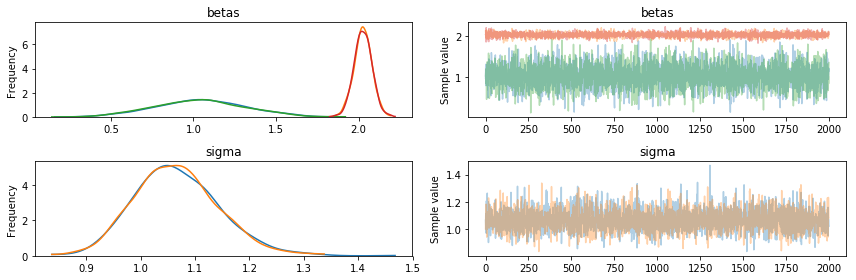

In [98]:
pm.traceplot(trace_gls)
betas_est_bayes = np.mean(trace_gls['betas'], axis=0)
sd_est_bayes = np.mean(trace_gls['sigma'])
var_est_bayes = np.cov(trace_gls['betas'].T)
print('Estimated params, bayes: %s' % (betas_est_bayes,))
print('Estimated sd, bayes: %s' % (sd_est_bayes,))
var_est_bayes

In [129]:
V_inv = np.linalg.inv(V)
betas_gls_est = np.linalg.inv(X.T.dot(V_inv).dot(X)).dot(X.T).dot(V_inv).dot(y_gls)
print(betas_gls_est)
print(sm.GLS(y_gls, X, sigma=V).fit().params)
sigma_sq_gls = np.sum((y_gls - X.dot(betas_gls_est))**2) / (N - 2)
print(np.linalg.inv(X.T.dot(V_inv * sigma_sq_gls).dot(X)))
print(sm.GLS(y_gls, X, sigma=V).fit().cov_params())

[1.03865817 2.02483419]
[1.03865817 2.02483419]
[[0.07354155 0.00039093]
 [0.00039093 0.0027688 ]]
[[0.07312953 0.00038874]
 [0.00038874 0.00275329]]


## Ridge
To be continued!

Why on earth is the ridge analytical solution not the same as when specifing a normal
prior on the parameters with mean 0 and variance $\lambda^-1$?

In [141]:
X[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()
lambds = [0.1, 0.5, 1, 5, 10, 100]

b_ridge = np.zeros(6)
b_ridge_bayes = np.zeros(6)
for i, lambd in enumerate(lambds):
    b_ridge[i] = np.linalg.inv(X.T.dot(X) + lambd*np.eye(2)).dot(X.T).dot(y)[1]
    
    ridge_model = pm.Model()

    with ridge_model:
        betas = pm.Normal('betas', 0, lambd**-1, shape=2)
        sigma = pm.Uniform('sigma', lower=0, upper=10**6)
        y_obs = pm.Normal('y_obs', pm.math.dot(X, betas), sigma, observed=y)
        b_ridge_bayes[i] = pm.find_MAP()['betas'][1]
        #trace = pm.sample()
        #b_ridge_bayes[i] = np.mean(trace['betas'][:, 1])

logp = -227.14, ||grad|| = 3.7065: 100%|██████████| 26/26 [00:00<00:00, 2171.01it/s]          
logp = -224.9, ||grad|| = 10.85: 100%|██████████| 28/28 [00:00<00:00, 2234.28it/s]            
logp = -225.16, ||grad|| = 0.8118: 100%|██████████| 25/25 [00:00<00:00, 1793.82it/s]          
logp = -3.6546e+17, ||grad|| = 7.4947e+17: 100%|██████████| 20/20 [00:00<00:00, 2260.41it/s]  
logp = -3.6546e+17, ||grad|| = 7.4947e+17: 100%|██████████| 20/20 [00:00<00:00, 1957.35it/s]  
logp = -261.71, ||grad|| = 3.4674e-07: 100%|██████████| 22/22 [00:00<00:00, 2106.49it/s]      


Text(0,0.5,'$\\beta_{1}$')

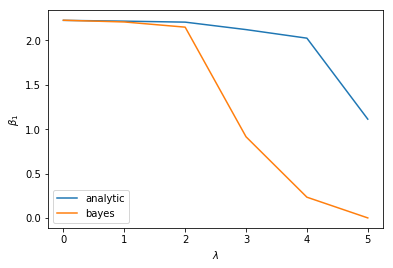

In [142]:
plt.plot(b_ridge)
plt.plot(b_ridge_bayes)
plt.legend(['analytic', 'bayes'])
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$\beta_{1}$')